In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [3]:
#Read in the data
df = pd.read_csv(r"C:\Users\Peter Villarreal\Desktop\Data Analytics\Datasets\texas_car_crashes\texas_car_crashes - texas_car_crashes.csv")
#Lets look at the data
df.head()

C:\Users\Peter Villarreal\AppData\Local\Temp\ipykernel_5688\458745912.py:2: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\Peter Villarreal\Desktop\Data Analytics\Datasets\texas_car_crashes\texas_car_crashes - texas_car_crashes.csv")


,Crash ID,$1000 Damage to Any One Person's Property,Active School Zone Flag,Adjusted Average Daily Traffic Amount,Adjusted Roadway Part,At Intersection Flag,Average Daily Traffic Amount,Average Daily Traffic Year,Bridge Detail,City,...,Vehicle Damage Rating 1 - Severity,Vehicle Defect 1,Citation,Person Age,Person Alcohol Result,Person Drug Test Result,Person Ethnicity,Person Gender,Person Injury Severity,Person Type
0,18038521,Yes,NO,127485,1 - MAIN/PROPER LANE,False,127485,2019,NOT APPLICABLE,AUSTIN,...,1 - DAMAGED 1 MINIMUM,No Data,No Data,22,No Data,97 - NOT APPLICABLE,B - BLACK,2 - FEMALE,N - NOT INJURED,1 - DRIVER
1,18042943,Yes,NO,126150,1 - MAIN/PROPER LANE,False,126150,2019,NOT APPLICABLE,AUSTIN,...,4 - DAMAGED 4,No Data,No Data,22,No Data,97 - NOT APPLICABLE,W - WHITE,1 - MALE,N - NOT INJURED,1 - DRIVER
2,18042943,Yes,NO,126150,1 - MAIN/PROPER LANE,False,126150,2019,NOT APPLICABLE,AUSTIN,...,4 - DAMAGED 4,No Data,No Data,35,No Data,97 - NOT APPLICABLE,H - HISPANIC,1 - MALE,N - NOT INJURED,1 - DRIVER
3,18042945,No,NO,No Data,1 - MAIN/PROPER LANE,False,No Data,No Data,NOT APPLICABLE,AUSTIN,...,2 - DAMAGED 2,No Data,No Data,120,No Data,97 - NOT APPLICABLE,99 - UNKNOWN,99 - UNKNOWN,99 - UNKNOWN,99 - UNKNOWN
4,18042945,No,NO,No Data,1 - MAIN/PROPER LANE,False,No Data,No Data,NOT APPLICABLE,AUSTIN,...,1 - DAMAGED 1 MINIMUM,No Data,No Data,120,No Data,97 - NOT APPLICABLE,99 - UNKNOWN,99 - UNKNOWN,99 - UNKNOWN,99 - UNKNOWN


In [4]:
## A little EDA on the first dataset
age_gender_alcohol = df[["Person Age", "Person Gender", "Person Alcohol Result"]]
age_gender_alcohol.head()

# Obsviously this needs to be cleaned up (unrealistic age limits ex: 120 & a ton of different types of NaNs like "UNKNOWNs", "No Data")

,Person Age,Person Gender,Person Alcohol Result
0,22,2 - FEMALE,No Data
1,22,1 - MALE,No Data
2,35,1 - MALE,No Data
3,120,99 - UNKNOWN,No Data
4,120,99 - UNKNOWN,No Data


In [5]:
## Cleaning up the age_gender_alcohol dataframe (keep in mind that due to different data types, cleaning will need different methods)

# First lets convert any age of triple digits into NaN (not applicable or missing data)
age = age_gender_alcohol["Person Age"].str.len()
age_gender_alcohol.loc[age > 2, "Person Age"] = np.nan
age_gender_alcohol.head()

,Person Age,Person Gender,Person Alcohol Result
0,22,2 - FEMALE,No Data
1,22,1 - MALE,No Data
2,35,1 - MALE,No Data
3,NaN,99 - UNKNOWN,No Data
4,NaN,99 - UNKNOWN,No Data


In [6]:
## Now that these extreme ages have been converted into NaN, we can now proceed to turning the rest of the missing values ("99 - UNKNOWN" and "No Data") into NaN
age_gender_alcohol_clean = pd.DataFrame(age_gender_alcohol, columns = ["Person Age", "Person Gender", "Person Alcohol Result"])
age_gender_alcohol_clean = age_gender_alcohol.replace(["NaN", "99 - UNKNOWN", "No Data"], "NaN", regex=True)
age_gender_alcohol_clean.head()

# The result of this gives us all missing values to be the same (all are now "NaN" instead of a whole different array of missing codes)
# Now we can drop the "NaN"s

,Person Age,Person Gender,Person Alcohol Result
0,22,2 - FEMALE,NaN
1,22,1 - MALE,NaN
2,35,1 - MALE,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [7]:
df_semiclean = age_gender_alcohol_clean.dropna()
df_semiclean.head()

,Person Age,Person Gender,Person Alcohol Result
0,22,2 - FEMALE,NaN
1,22,1 - MALE,NaN
2,35,1 - MALE,NaN
5,21,2 - FEMALE,1 - POSITIVE
6,24,1 - MALE,NaN


In [8]:
## Here I am "filtering out" any remaining "NaN"s from the previous dataframe

alcohol_results = df_semiclean["Person Alcohol Result"].isin(["1 - POSITIVE", "2 - NEGATIVE"])
no_NaN_df = df_semiclean[alcohol_results]
no_NaN_df.head()

,Person Age,Person Gender,Person Alcohol Result
5,21,2 - FEMALE,1 - POSITIVE
74,29,1 - MALE,1 - POSITIVE
136,29,2 - FEMALE,1 - POSITIVE
435,41,1 - MALE,1 - POSITIVE
554,19,2 - FEMALE,1 - POSITIVE


In [9]:
## I now need to convert the entries "1 - MALE" and "2 - FEMALE" & "1 - POSITIVE" and "2 - NEGATIVE" into categories
# For Person Gender: 1 = MALE & 2 = FEMALE
# For Person Alcohol Result: 1 = POSITIVE, 2 = NEGATIVE

gender_alcohol_convert = pd.DataFrame(no_NaN_df, columns = ["Person Gender", "Person Alcohol Result"])
df_clean = no_NaN_df.replace(["2 - FEMALE", "1 - MALE", "1 - POSITIVE", "2 - NEGATIVE"], ["2", "1", "1", "2"], regex=True)
df_clean.head()

,Person Age,Person Gender,Person Alcohol Result
5,21,2,1
74,29,1,1
136,29,2,1
435,41,1,1
554,19,2,1


In [12]:
## Looks like the previous dataframe "df_clean" is looking pretty clean, however some "NaN" entries are still popping up???
# I can verify this by running a .groupby() and a .count() on each column in order to spot them
# How this column is still left with a single "NaN" entry after getting rid of all other ones with the .dropna() function is way beyond me!!

df_clean.groupby("Person Gender").count()

,Person Age,Person Alcohol Result
Person Gender,,
1,260,260
2,91,91
NaN,1,1


In [13]:
# Clearly the "Person Alcohol Result" column did not have any "NaN"s left

df_clean.groupby("Person Alcohol Result").count()

,Person Age,Person Gender
Person Alcohol Result,,
1,314,314
2,38,38


In [14]:
# Clearly the "Person Age" column did not have any "NaN"s left either

df_clean.groupby("Person Age").count()

,Person Gender,Person Alcohol Result
Person Age,,
17,1,1
18,5,5
19,9,9
20,7,7
21,22,22
22,17,17
23,21,21
24,25,25
25,25,25


In [15]:
## Since the culprit of the ackward "NaN" entry was the column "Person Gender", I "re-filter" using the .isin() function

gender_results = df_clean["Person Gender"].isin(["1", "2"])
clean_df = df_clean[gender_results]
clean_df.head()

,Person Age,Person Gender,Person Alcohol Result
5,21,2,1
74,29,1,1
136,29,2,1
435,41,1,1
554,19,2,1


In [16]:
# In order to verify that clean_df is COMPLETELY wipedout of "NaN"s I will re-run a .groupby() + .count() functions
# Verified: no more "NaN"s!

clean_df.groupby("Person Gender").count()

,Person Age,Person Alcohol Result
Person Gender,,
1,260,260
2,91,91


In [19]:
## Now that we have a clean dataframe within the columns specified and all entries have been converted into a 'int32' type we can analyze

clean_df = clean_df.astype('int')
clean_df.dtypes

Person Age               int32
Person Gender            int32
Person Alcohol Result    int32
dtype: object

In [25]:
clean_df.head()

,Person Age,Person Gender,Person Alcohol Result
5,21,2,1
74,29,1,1
136,29,2,1
435,41,1,1
554,19,2,1


In [21]:
## Are there correlations?
# I hypothesize that "Person Age" will have a correlation with "Person Alcohol Result"
# Very weak positive correlation coefficient (0.211786) 

clean_df.corr(method = 'pearson')

,Person Age,Person Gender,Person Alcohol Result
Person Age,1.000000,-0.074950,0.211786
Person Gender,-0.074950,1.000000,-0.038747
Person Alcohol Result,0.211786,-0.038747,1.000000


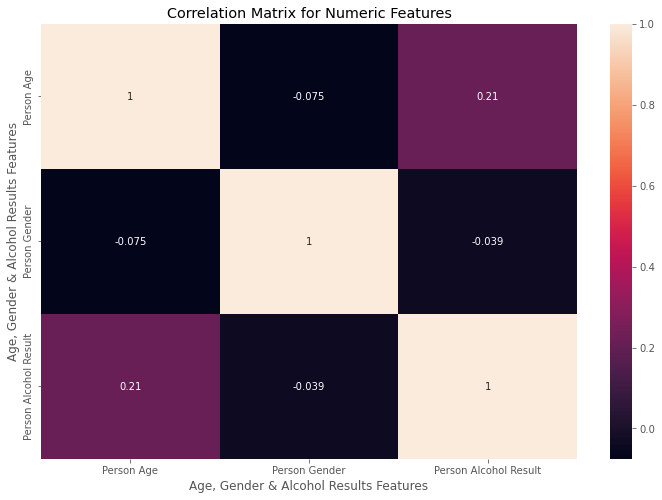

In [23]:
# Correlation matrix

correlation_matrix = clean_df.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True)

plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Age, Gender & Alcohol Results Features')
plt.ylabel('Age, Gender & Alcohol Results Features')

plt.show()

In [26]:
## Here I am sorting the values by Age so that I can better see the Alcohol Results agains Age

clean_df.sort_values("Person Age")

,Person Age,Person Gender,Person Alcohol Result
23243,17,1,1
12998,18,2,1
3383,18,1,1
26213,18,1,1
14951,18,1,1
...,...,...,...
3939,67,1,1
16915,67,1,1
2674,68,1,2
25047,69,1,1


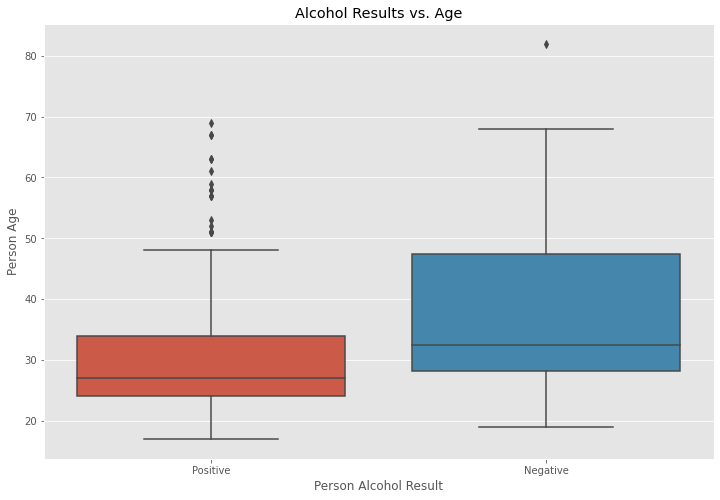

In [30]:
## Here I am using a Boxplot to visualize the Alcohol Results vs. Age
# There could be a slight increase of Positive results with younger age

ax = sns.boxplot(data=clean_df, x='Person Alcohol Result', y='Person Age')
ax.set_xticklabels(["Positive", "Negative"])
ax.set_title("Alcohol Results vs. Age")
plt.show()